In [25]:
# auto reload on file change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image
import torchvision.models as models
from tqdm import tqdm

In [27]:
from src.yolov8 import *
from src.yoloTrain import *
from src.yoloDataset import *
from src.yoloLoss import *
from src.utils import *

In [28]:
from src.datasetSetup import srediDataset
srediDataset("datasetoviraw", "datasetyolo.zip")

File downloaded or caches
File unziped
Dataset je uspesno organizovan
Finished dataset customization


In [29]:
features_yolo = nn.Sequential(
    nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2) 
)
def collate_fn(batch):
    images, targets = zip(*batch)
    images = list(images)
    target_tensors = []
    
    for target in targets:
        xx = target[0][:,:,0,:]
        boxes = torch.tensor(xx, dtype=torch.float32)
        labels = torch.tensor(target[1], dtype=torch.int64)
        target_tensor = torch.cat((boxes, labels), dim=2)
        target_tensors.append(target_tensor)
    
    target_tensors = torch.stack(target_tensors)   

    return images, target_tensors

In [30]:
train_img_dir = 'datasetoviraw\datasetyolo.zip_unzip\wtrain\images'
train_labels_dir = 'datasetoviraw\datasetyolo.zip_unzip\wtrain\labels'


train_dataset = YoloV8Dataset(train_img_dir, train_labels_dir, transform=transform_yolo)
train_loader = DataLoader(train_dataset, batch_size=batch_size_yolo, shuffle=True, num_workers=0, collate_fn=collate_fn)

val_img_dir = 'datasetoviraw\datasetyolo.zip_unzip\wvalid\images'
val_labels_dir = 'datasetoviraw\datasetyolo.zip_unzip\wvalid\labels'


val_dataset = YoloV8Dataset(val_img_dir, val_labels_dir, transform=transform_yolo)
val_loader = DataLoader(val_dataset, batch_size=batch_size_yolo, shuffle=True, num_workers=0, collate_fn=collate_fn)

In [31]:
model = YOLOv8(features=features_yolo)
optimizer = optim.Adam(model.fc_layers.parameters(), lr=0.001)

In [32]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)
print(device)

cpu


In [33]:
feature_size_yolo = 7  
num_bboxes_yolo = 1 
num_classes_yolo = 4 
lambda_coord = 5.0
lambda_noobj = 0.5
learning_rate = 1e-3

In [ ]:
backbone = models.resnet18(pretrained=True)
backbone = nn.Sequential(*list(backbone.children())[:-2]) 

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
yolo_loss = YOLOv8Loss(feature_size=7, num_bboxes=1, num_classes=4, lambda_box=1.0, lambda_cls=1.0, lambda_df=1.0, phi=0.0005) 

In [43]:
criterion = YOLOv8Loss(feature_size=7, num_bboxes=1, num_classes=4, lambda_box=1.0, lambda_cls=1.0, lambda_df=1.0, phi=0.0005)
for epoch in range(num_epochs_yolo):
    epoch_loss = train(model, optimizer, train_loader, device, criterion)
    val_loss = validate(model, val_loader, device, criterion)
    print(f'Epoch {epoch+1}/{num_epochs_yolo}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')


Training Epoch:   0%|          | 0/77 [00:00<?, ?it/s]C:\Users\lanal\AppData\Local\Temp\ipykernel_15644\1619369655.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes = torch.tensor(xx, dtype=torch.float32)
C:\Users\lanal\AppData\Local\Temp\ipykernel_15644\1619369655.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(target[1], dtype=torch.int64)
Training Epoch:  19%|█▉        | 15/77 [00:22<01:32,  1.49s/it]


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'yolov8.pth')

In [ ]:
import torch


def save_model(model, path):
    torch.save(model, path)

def load_model(path):
    model = torch.load(path)
    model.eval()  # Postavi model u režim evaluacije
    return model

# Primer korišćenja
model = YOLOv8(features_yolo)  # Inicijalizuj instancu modela

# Sačuvaj model
save_model(model, 'full_model.pth')

# Učitaj model
loaded_model = load_model('full_model.pth')


In [ ]:
model = YOLOv8(features_yolo)
model.load_state_dict(torch.load('yolov8.pth'))
model.eval()


YOLOv8(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

C:\Users\lanal\AppData\Local\Temp\ipykernel_15644\1619369655.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes = torch.tensor(xx, dtype=torch.float32)
C:\Users\lanal\AppData\Local\Temp\ipykernel_15644\1619369655.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(target[1], dtype=torch.int64)


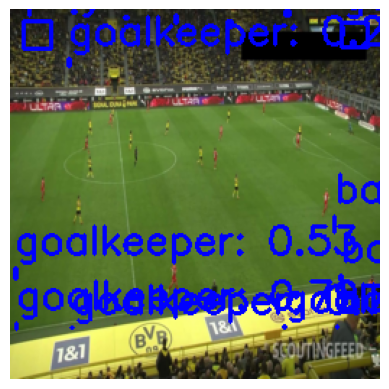

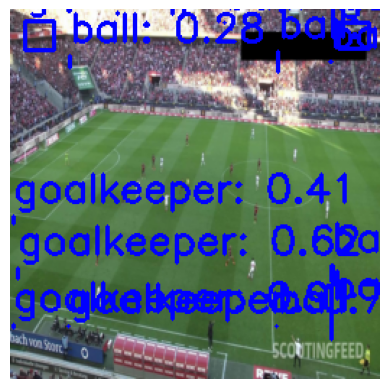

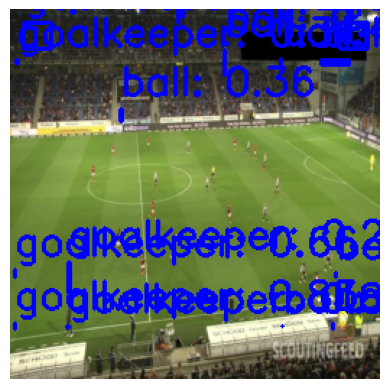

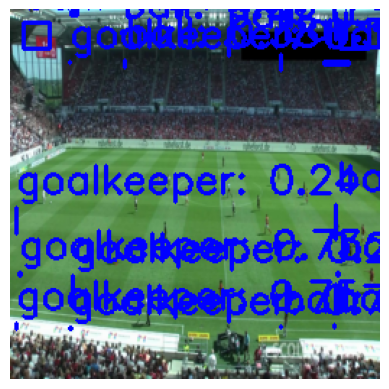

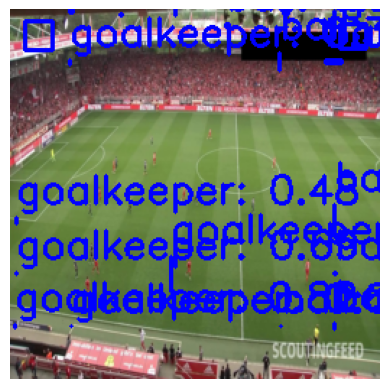

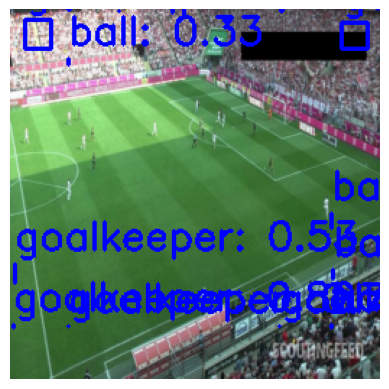

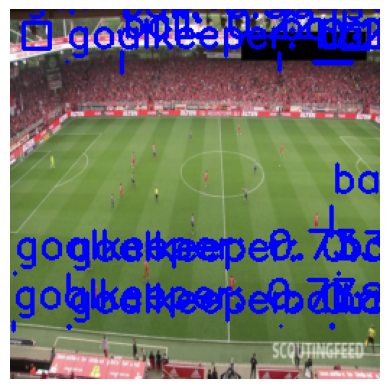

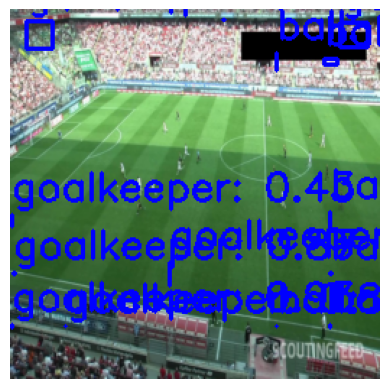

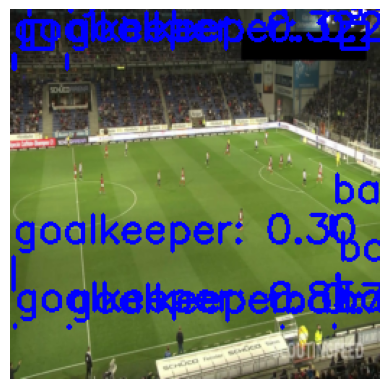

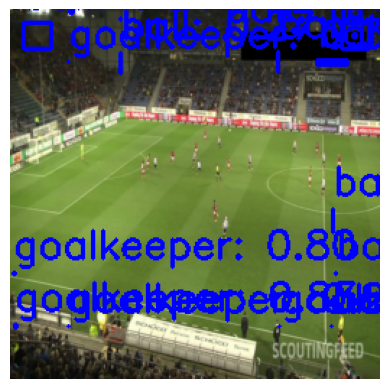

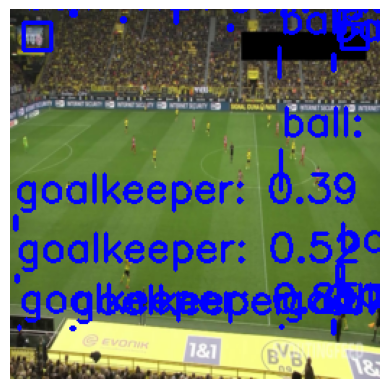

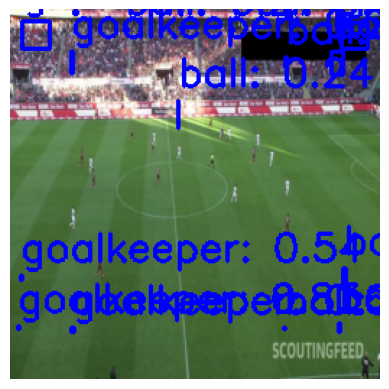

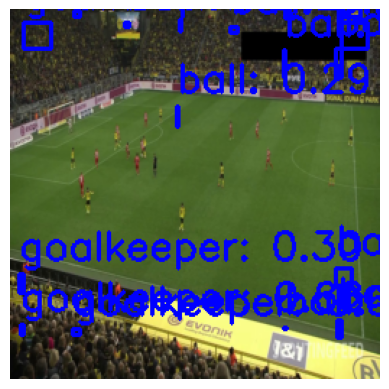

In [42]:
import torch
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np

# Assuming CLASSES_YOLO and YOLOv8, YoloV8Dataset, collate_fn, features_yolo are already defined somewhere
CLASSES_YOLO = ['ball', 'goalkeeper', 'player', 'referee']

# Define your transformation
transform_yolo = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

test_img_dir = 'datasetoviraw/datasetyolo.zip_unzip/wtest/images'
test_labels_dir = 'datasetoviraw/datasetyolo.zip_unzip/wtest/labels'

# Initialize dataset and dataloader
test_dataset = YoloV8Dataset(test_img_dir, test_labels_dir, transform=transform_yolo)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=0, collate_fn=collate_fn)

# Load the model
model_path = 'yolov8fejl.pth'
model = YOLOv8(features_yolo)
model.load_state_dict(torch.load(model_path))
model.eval()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

def plot_image_with_boxes(image, boxes, labels, scores):
    img = image.permute(1, 2, 0).cpu().numpy()
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = (img * 255).astype(np.uint8)

    for box, label, score in zip(boxes, labels, scores):
        if score > 0.2:  
            if label < len(CLASSES_YOLO):  
                box = box.cpu().numpy().astype(int)
                img = cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
                label_str = CLASSES_YOLO[label]
                img = cv2.putText(img, f'{label_str}: {score:.2f}', (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
            else:
                print(f"Label index {label} out of range for CLASSES list.")
                print(f"Labels: {labels}")
                print(f"Classes length: {len(CLASSES_YOLO)}")

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

for images, targets in test_loader:
    images = torch.stack(images).to(device)
    with torch.no_grad():
        prediction = model(images)

        batch_size, grid_size, _, num_classes_plus_5 = prediction.shape
        num_classes = num_classes_plus_5 - 5

        for batch_idx in range(batch_size):
            image = images[batch_idx]
            boxes, labels, scores = [], [], []

            for i in range(grid_size):
                for j in range(grid_size):
                    cell_prediction = prediction[batch_idx, i, j]
                    cell_scores = cell_prediction[:num_classes]
                    class_label = torch.argmax(cell_scores)
                    confidence = cell_prediction[-1]
                    x_center, y_center, width, height = cell_prediction[num_classes:num_classes+4]

                    score = torch.max(cell_scores) * confidence

                    if score > 0.2:  # Adjust the threshold as needed
                        # Convert center coordinates to top-left and bottom-right coordinates
                        x_center = (j + x_center) / grid_size  # Adjust x_center with grid offset
                        y_center = (i + y_center) / grid_size  # Adjust y_center with grid offset
                        width /= grid_size
                        height /= grid_size

                        box = [
                            int((x_center - width / 2) * 256),  # top-left x
                            int((y_center - height / 2) * 256),  # top-left y
                            int((x_center + width / 2) * 256),  # bottom-right x
                            int((y_center + height / 2) * 256)   # bottom-right y
                        ]
                        boxes.append(torch.tensor(box))
                        labels.append(class_label)
                        scores.append(score)

            plot_image_with_boxes(image, boxes, labels, scores)
